In [1]:
'''
Add noise using Neurologica filter
'''

'\nAdd noise using Neurologica filter\n'

In [11]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import copy

import ct_projector.projector.numpy.parallel as ct_para

img_clean shape: (148, 512, 512)


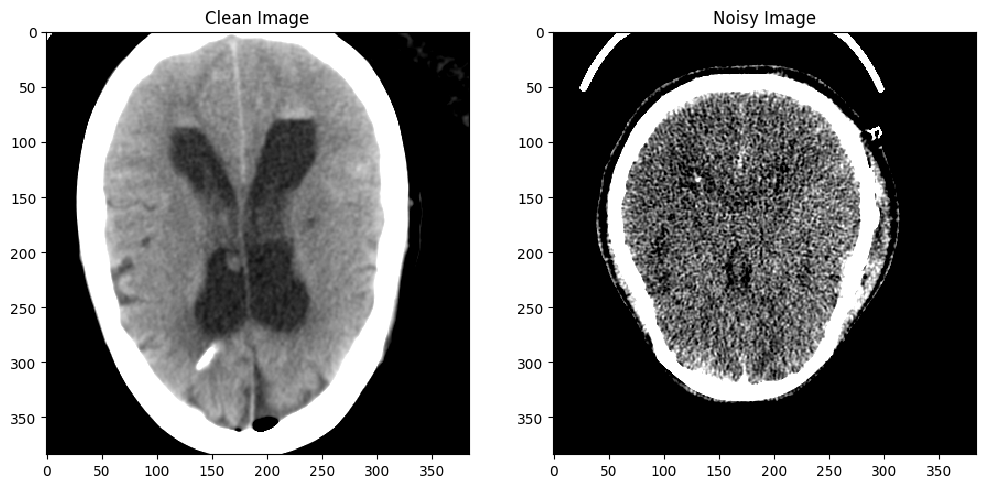

In [12]:
# Load the images, we investigate a thick slice and thin slice
# We will add noise to the thick slice so it looks like the thin slice

sitk_img_clean = sitk.ReadImage('soft_5mm_0.nii.gz')
sitk_img_clean = sitk.ReadImage('/mnt/camca_NAS/denoising/Data/fixedCT/00214938/0000455723/img_thinslice.nii.gz')
sitk_img_noise = sitk.ReadImage('soft_thins_0.nii.gz')
# sitk_img_noise = sitk.ReadImage('/mnt/camca_NAS/denoising/Data/fixedCT/00214938/0000455723/img_thinslice.nii.gz')

img_clean = sitk.GetArrayFromImage(sitk_img_clean).astype(np.float32)
img_noise = sitk.GetArrayFromImage(sitk_img_noise).astype(np.float32)

img_clean[img_clean < -1024] = -1024
img_noise[img_noise < -1024] = -1024
print('img_clean shape:', img_clean.shape)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_clean[img_clean.shape[0] // 2, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(img_noise[img_noise.shape[0] // 2, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Noisy Image')
plt.show()

In [13]:
# Load the 2d geometry
projector = ct_para.ct_projector()
projector.from_file('pcd_parallel_6x5_512.cfg')
projector.dx = sitk_img_noise.GetSpacing()[0]
projector.dy = sitk_img_noise.GetSpacing()[1]
projector.dz = sitk_img_noise.GetSpacing()[2]
projector.nx = img_noise.shape[2]
projector.ny = img_noise.shape[1]
projector.dv = projector.dz
print('[projector]')
for k in vars(projector):
    print(k, '=', getattr(projector, k), flush=True)

[projector]
nview = 1440
rotview = 720
nu = 440
nv = 1
nx = 512
ny = 512
nz = 1
dx = 0.6015625
dy = 0.6015625
dz = 0.7070000171661377
cx = 0
cy = 0
cz = 0
dsd = 10596.0
dso = 10366.0
du = 0.70314
dv = 0.7070000171661377
off_u = 4.25
off_v = 0
geometry = <configparser.ConfigParser object at 0x78e2e78e3cd0>


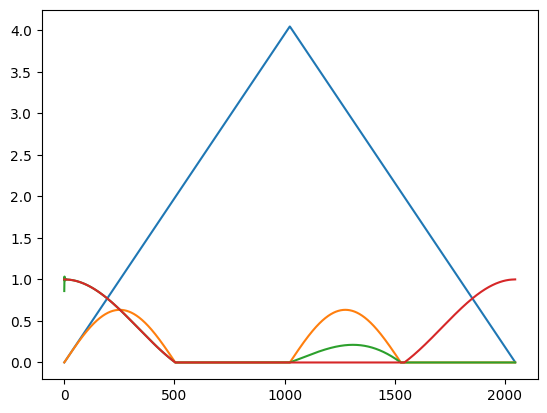

In [14]:
# load the filter
def get_additional_filter_to_rl(filename, nu, du, nview, ninterp=20):
    '''
    Compose the filter that is on top of the RL filter
    '''
    custom_filter = np.fromfile(filename, np.float32)

    # these are the parameters after interleaving
    # the filter will be applied on the interleaved data
    nu *= 2
    du /= 2

    # compose rl filter
    rl_filter = np.zeros([2 * nu - 1], np.float32)
    k = np.arange(len(rl_filter)) - (nu - 1)
    for i in range(len(rl_filter)):
        if k[i] == 0:
            rl_filter[i] = 1 / (4 * du * du)
        elif k[i] % 2 != 0:
            rl_filter[i] = -1 / (np.pi * np.pi * k[i] * k[i] * du * du)
    frl_filter = np.fft.fft(rl_filter, len(custom_filter))
    frl_filter = np.abs(frl_filter)

    frl_filter = frl_filter * len(frl_filter) / nview * du * 2

    ratio = custom_filter / frl_filter

    # A smooth transition from 1 to the target ratio to avoid instability at the center
    ratio_fix = ratio.copy()
    ratio_fix[:ninterp] = 1 + (ratio[ninterp] - 1) * np.arange(ninterp) / ninterp
    ratio_fix = ratio_fix.astype(np.float32)
    ratio_fix[len(ratio_fix) // 2:] = ratio_fix[len(ratio_fix) // 2:0:-1]

    plt.figure()
    plt.plot(frl_filter)
    plt.plot(custom_filter)
    plt.plot(ratio)
    plt.plot(ratio_fix)
    plt.show()

    return ratio_fix

custom_additional_filter = get_additional_filter_to_rl('softTissueKernel_65', projector.nu, projector.du, projector.nview)

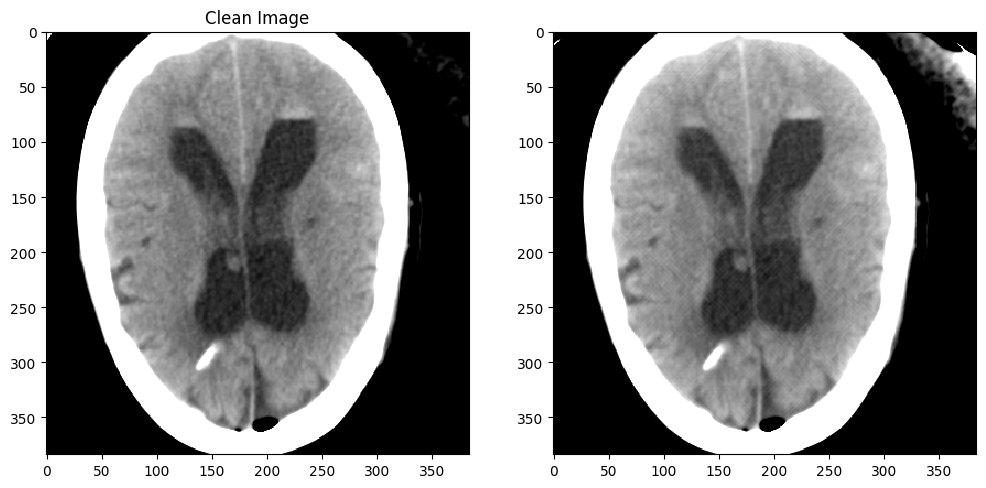

In [15]:
# forward projection
img0 = img_clean[[img_clean.shape[0] // 2], ...].copy()
img0 = (img0[np.newaxis, ...] + 1000) / 1000 * 0.019  # convert to attenuation coefficient in mm-1
angles = projector.get_angles()
prjs = ct_para.distance_driven_fp(projector, img0, angles)

# verify forward projection
fprjs = ct_para.ramp_filter(projector, prjs, 'rl')
recon = ct_para.distance_driven_bp(projector, fprjs, angles, True)
recon = recon[0, 0] / 0.019 * 1000 - 1000

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_clean[img_clean.shape[0] // 2, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(recon[64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)

In [7]:
# add noise
def add_noise(prj: np.ndarray, N0: float, dose_factor: float, seed: int=None):
    if seed is not None:
        np.random.seed(seed)

    # add noise
    if N0 > 0 and dose_factor < 1:
        prj = prj + np.sqrt((1 - dose_factor) / dose_factor * np.exp(prj) / N0) * np.random.normal(size=prj.shape)
        prj = prj.astype(np.float32)

    return prj

# add noise to the projection
N0 = 1e6
dose_factor = 0.2

Text(0.5, 1.0, 'THINS Average 3 times Image')

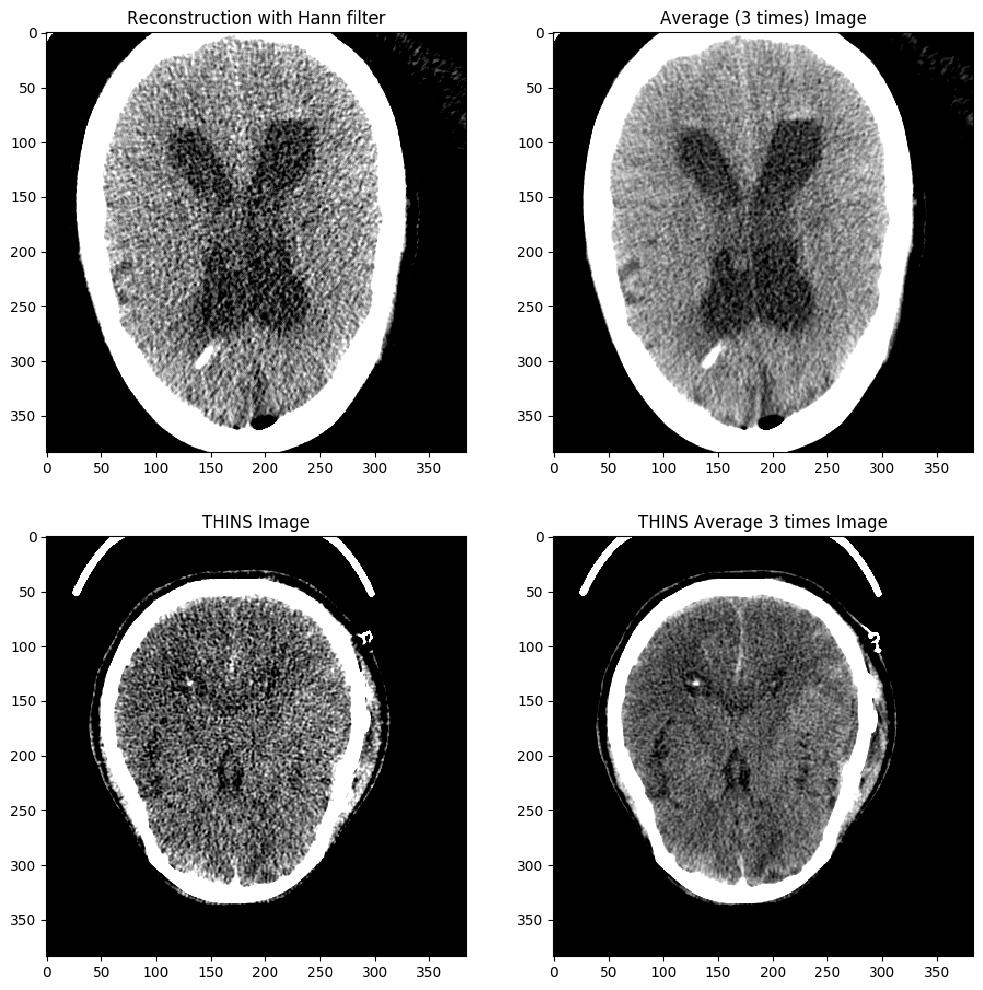

In [8]:
# Reconstruction: direct hann filter
recon_hanns = []

for i in range(3):
    noise_of_prjs = add_noise(prjs, N0, dose_factor, i) - prjs
    # We should only add noise to the projection noise so that the low-pass filter
    # will not be applied twice on the reconstructed image. Note that the original image
    # is already reconstructed with a low-pass filter.
    fnoise = ct_para.ramp_filter(projector, noise_of_prjs, 'hann')
    recon_hann = ct_para.distance_driven_bp(projector, fnoise, angles, True) + img0
    recon_hann = recon_hann[0, 0] / 0.019 * 1000 - 1000
    recon_hanns.append(recon_hann)

recon_hanns = np.array(recon_hanns)
recon_hann_avg = recon_hanns.mean(axis=0)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(recon_hanns[0, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Reconstruction with Hann filter')
plt.subplot(2, 2, 2)
plt.imshow(recon_hann_avg[64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Average (3 times) Image')
plt.subplot(2, 2, 3)
plt.imshow(img_noise[img_noise.shape[0] // 2, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('THINS Image')
plt.subplot(2, 2, 4)
plt.imshow(img_noise[img_noise.shape[0] // 2 - 1:img_noise.shape[0] // 2 + 2, 64:-64, 64:-64].mean(0), cmap='gray', vmin=0, vmax=80)
plt.title('THINS Average 3 times Image')

Text(0.5, 1.0, 'THINS Average 3 times Image')

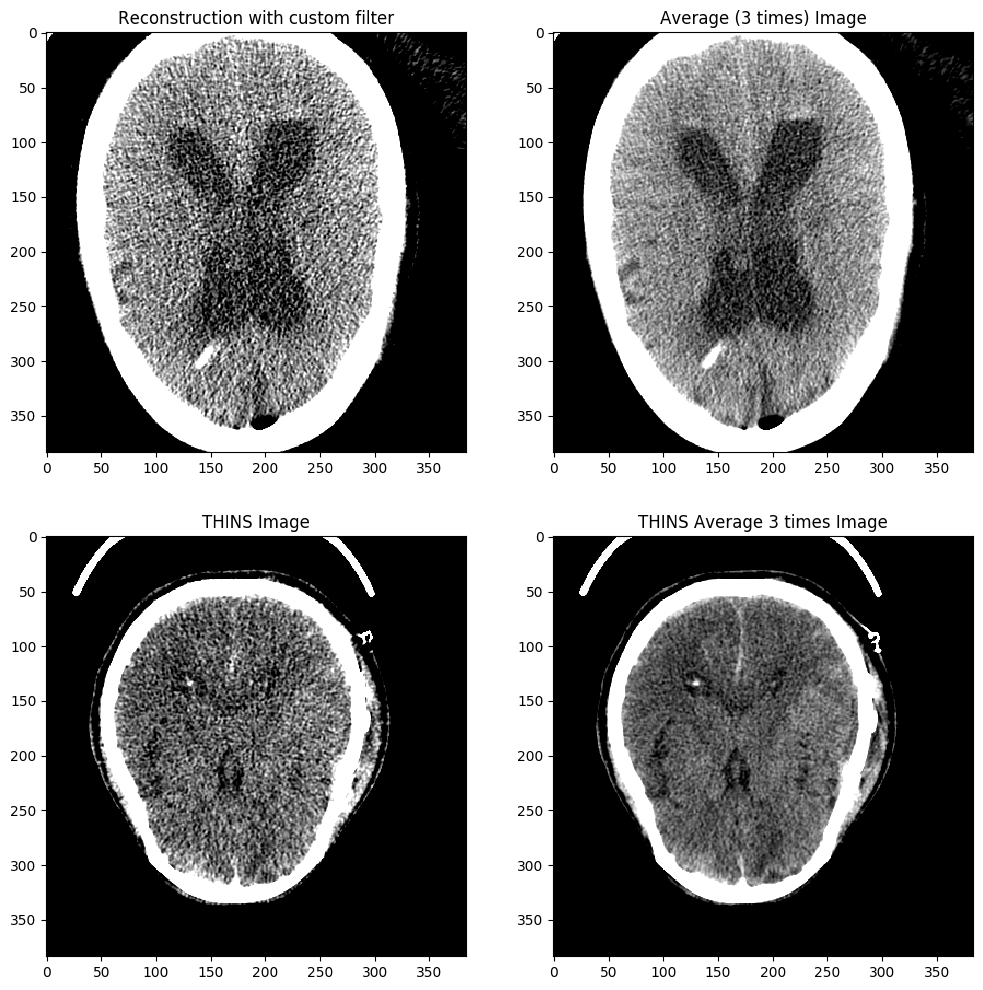

In [16]:
# Reconstruction: interleave and custom filter
def interleave_filter_and_recon(projector, prjs, custom_filter,angles):
    # interleave the filter
    projector = copy.deepcopy(projector)
    prjs = prjs.copy()

    # make sure the detector center is within the central pixel (usually 0.25 of a pixel)
    # so that when interleaving the detectors the length will be twice the original
    offu = int(projector.off_u)
    projector.off_u -= offu
    projector.nu -= 2 * offu
    prjs = prjs[..., :-2 * offu]

    # interleave the projections
    new_prjs = np.zeros(list(prjs.shape[:-1]) + [prjs.shape[-1] * 2])
    for iview in range(new_prjs.shape[1]):
        iview_opp = (iview + new_prjs.shape[1] // 2) % new_prjs.shape[1]
        new_prjs[:, iview, :, 1::2] = prjs[:, iview, :, :]
        new_prjs[:, iview, :, 0::2] = prjs[:, iview_opp, :, ::-1]
    prjs = new_prjs
    projector.off_u = 0
    projector.nu = prjs.shape[-1]
    projector.du = projector.du / 2

    # build rl filter
    nu = prjs.shape[-1]
    du = projector.du
    rl_filter = np.zeros([2 * nu - 1], np.float32)
    k = np.arange(len(rl_filter)) - (nu - 1)
    for i in range(len(rl_filter)):
        if k[i] == 0:
            rl_filter[i] = 1 / (4 * du * du)
        elif k[i] % 2 != 0:
            rl_filter[i] = -1 / (np.pi * np.pi * k[i] * k[i] * du * du)
    frl_filter = np.fft.fft(rl_filter, len(custom_filter))
    frl_filter = np.abs(frl_filter)

    frl_filter = frl_filter * len(frl_filter) / prjs.shape[1] * du * 2

    custom_filter = frl_filter * custom_filter

    # filter the projection
    fprj = np.fft.fft(prjs, len(custom_filter), axis=-1)
    fprj = fprj * custom_filter
    fprj = np.fft.ifft(fprj, axis=-1)[..., :prjs.shape[-1]]
    fprj = fprj.real.astype(np.float32) * np.pi / len(custom_filter) / 2
    fprj = np.copy(fprj, 'C')

    # reconstruction
    recon = ct_para.pixel_driven_bp(projector, fprj, angles)

    return recon


recon_customs = []

for i in range(3):
    noise_of_prjs = add_noise(prjs, N0, dose_factor, i) - prjs
    recon_custom = interleave_filter_and_recon(projector, noise_of_prjs, custom_additional_filter,angles) + img0
    recon_custom = recon_custom[0, 0] / 0.019 * 1000 - 1000
    recon_customs.append(recon_custom)
recon_customs = np.array(recon_customs)
recon_custom_avg = recon_customs.mean(axis=0)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(recon_customs[0, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Reconstruction with custom filter')
plt.subplot(2, 2, 2)
plt.imshow(recon_custom_avg[64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('Average (3 times) Image')
plt.subplot(2, 2, 3)
plt.imshow(img_noise[img_noise.shape[0] // 2, 64:-64, 64:-64], cmap='gray', vmin=0, vmax=80)
plt.title('THINS Image')
plt.subplot(2, 2, 4)
plt.imshow(img_noise[img_noise.shape[0] // 2 - 1:img_noise.shape[0] // 2 + 2, 64:-64, 64:-64].mean(0), cmap='gray', vmin=0, vmax=80)
plt.title('THINS Average 3 times Image')
